<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [2522]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport

import itertools
import json

import seaborn as sns
import matplotlib.pyplot as plt

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
import category_encoders as ce
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
import plotly.express as px
import datatable as dt
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
min_max_scaler = MinMaxScaler()
pf = PolynomialFeatures()
mlb = MultiLabelBinarizer()
%matplotlib inline

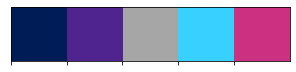

In [2523]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

In [2524]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1
Pandas       : 1.2.4


In [2525]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [2526]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

## Функции

In [2527]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def check_features(dfs: list, names: list):
    '''Сравнивает признаки и типы данных между датасетами'''
    for df in itertools.permutations(zip(names, dfs)):
        print(f"Present in {df[0][0]}, missing in {df[1][0]}:")
        print(set(df[0][1].columns).difference(df[1][1].columns))
        print('-------------'*8)
        
        for col in set(df[0][1].columns).intersection(df[1][1].columns):
            if df[0][1][col].dtypes != df[1][1][col].dtypes:
                print(f"{col}\n{df[0][0]}: {df[0][1][col].dtypes}\n{df[1][0]}: {df[1][1][col].dtypes}")
                print('-------------'*4)
        print('_____________'*8)
        print()
        

def get_model_name(url):
    '''достаёт название модели из ссылки, в случае ошибки пишет об этом'''
    try:
        return url.split('/')[7]
    except:
        print(f'NaN found in {url}')
        return np.nan
    
def get_ownership(row):
    '''Переформатирует из "1 год и 6 месяцев" в 1.5'''
    try:
        if (('год' in row) or ('лет' in row)) and ('месяц' in row):
            return int(row.split()[0])+(int(row.split()[3])/12)
        elif (('год' in row) or ('лет' in row)) and ('месяц' not in row):
            return int(row.split()[0])
        elif (('год' not in row) or ('лет' not in row)) and ('месяц' in row):
            return int(row.split()[0]) / 12
    except:
        pass    
    
    
def equipment_to_dict(row):
    '''переформатирует клетку в формат dict'''
    try:
        if isinstance(row, str):
            return json.loads(row)
        else:
            return row
    except:
        pass

    
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [2528]:
def dummy_cols(data, cat_cols):
    # создадим dummy-переменные для категориальных признаков
    X_cat = pd.get_dummies(data[cat_cols], columns=cat_cols)
    data = data.drop(cat_cols, axis=1).join(X_cat)
    return data

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
def barh_plot(df, cols, target_col):
    imp = pd.Series(f_classif(df[cols], df[target_col])[0], index=cols)
    imp.sort_values(inplace=True)
    imp.plot(kind='barh')
    plt.show()
    
def find_outliers(data):
    '''Find outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    bot = q1 - (1.5 * IQR)
    top = q3 + (1.5 * IQR)
    count = len(data[data < bot]) + len(data[data > top])

    print(f'Bot: {round(bot,3)}, Top: {round(top,3)}, Outliers: {count}')

def num_vis(col, title=None):
    '''Визуализировать числовые признаки'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
    sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')

    plt.show()
    
def pca_cols(data, col1, col2):
    '''Объединяет 2 числовых признака в 1'''
    arrays = data[[col1, col2]].values
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(arrays)
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    data[f'{col1}_{col2}_PCA'] = pca_data
    data = data.drop([col1, col2], axis=1)
    return data

In [2529]:
def catboost_reg(X, y, iterations=5000, eval_metric='MAPE', custom_metric=['R2', 'MAE'], log_y=False):
    '''Запускает CatBoostRegressor, возвращает модель и предсказанные значения'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
    

    model = CatBoostRegressor(iterations=iterations,
                          random_seed=RANDOM_SEED,
                          eval_metric=eval_metric,
                          custom_metric=custom_metric,
                          silent=True,
                         )
    
    model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )
    model.save_model(f'catboost_{VERSION}')
    

    predict = model.predict(X_test)
    
    if log_y:
        print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(predict)))*100:0.2f}%")
    else:
        print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    return model, predict


def create_submission(predict_submission, sample_submission=sample_submission, VERSION=VERSION):
    sample_submission['price'] = predict_submission
    sample_submission.to_csv(f'submission_{VERSION}.csv', index=False)
    print(sample_submission.head(10))

# Setup

In [2530]:
VERSION    = 5
#DIR_TRAIN  = '../archive/' # подключил к ноутбуку внешний датасет
#DIR_TEST   = '../sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [2531]:
train = pd.read_csv('train.csv') # собранный датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Некоторые объявления были закрыты после сбора url, так что цена могла не собраться. Удалим строки где price отсутствует

In [2532]:
train = train[train.price.isna() == False]

In [2533]:
train.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/110584...,белый,"{'back-brake': 'Disc', 'feeding': 'None', 'ful...",Всех приветствую Просьба диванных критиков и п...,2.0 л,115 л.с.,{},Бензин,...,механическая,NaN,3 или более,9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,370000.0
1,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/110604...,серебристый,"{'back-brake': 'Disc', 'feeding': 'None', 'ful...",Машина обслужена Зимой не эксплуатировалась Во...,2.0 л,115 л.с.,{},Бензин,...,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,360000.0
2,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/110606...,серый,"{'back-brake': 'Disc', 'feeding': 'None', 'ful...",Год выпуска 1989 Пробег 380 000 км Кузов седан...,2.3 л,136 л.с.,{},Бензин,...,механическая,NaN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,350000.0
3,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/110552...,синий,"{'back-brake': 'Disc', 'feeding': 'None', 'ful...",Продам Audi 100 2 0 ААЕ 1992 год Ввезена в РФ ...,2.0 л,101 л.с.,{},Бензин,...,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,320000.0
4,универсал 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/100/110583...,серебристый,"{'back-brake': 'Disc', 'feeding': 'None', 'ful...",Продаю AUDI 100 2 6E avant на МКПП Растаможена...,2.6 л,150 л.с.,"{'alloy-wheel-disks': True, 'tinted-glass': Tr...",Бензин,...,механическая,NaN,3 или более,7 месяцев,Дубликат,передний,Левый,Не требует ремонта,Растаможен,310000.0


In [2534]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92327 entries, 0 to 103793
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89060 non-null  object 
 1   brand                 92327 non-null  object 
 2   car_url               92327 non-null  object 
 3   color                 92327 non-null  object 
 4   complectation_dict    92261 non-null  object 
 5   description           92327 non-null  object 
 6   engineDisplacement    89060 non-null  object 
 7   enginePower           89060 non-null  object 
 8   equipment_dict        92327 non-null  object 
 9   fuelType              89060 non-null  object 
 10  image                 92326 non-null  object 
 11  mileage               89060 non-null  float64
 12  modelDate             0 non-null      float64
 13  model_info            0 non-null      float64
 14  model_name            89060 non-null  object 
 15  name              

In [2535]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [2536]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

### Объединение признаков

In [2537]:
check_features([train, test], ['train', 'test'])

Present in train, missing in test:
{'price'}
--------------------------------------------------------------------------------------------------------
productionDate
train: float64
test: int64
----------------------------------------------------
vehicleConfiguration
train: float64
test: object
----------------------------------------------------
model_info
train: float64
test: object
----------------------------------------------------
vendor
train: float64
test: object
----------------------------------------------------
parsing_unixtime
train: float64
test: int64
----------------------------------------------------
mileage
train: float64
test: int64
----------------------------------------------------
numberOfDoors
train: float64
test: int64
----------------------------------------------------
modelDate
train: float64
test: int64
----------------------------------------------------
sell_id
train: float64
test: int64
----------------------------------------------------
________________

**price** мы добавим и обозначим как 0

In [2538]:
test['price'] = 0

In [2539]:
train.price = train.price.astype('int64')

**model_info** - по сути, единственное полезное что там есть уже обозначено в **model_name**. Удаляем

In [2540]:
test.model_info[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [2541]:
test.drop(['model_info'], axis=1, inplace=True)
train.drop(['model_info'], axis=1, inplace=True)

**priceCurrency** в обоих датасетах представлен в рублях. Убираем за ненадобностью

In [2542]:
test.drop(['priceCurrency'], axis=1, inplace=True)
train.drop(['priceCurrency'], axis=1, inplace=True)

**vehicleConfiguration** - т.к в этом признаке представлены другие признаки - **bodyType, vehicleTransmission, engineDisplacement**, данный признак я не парсил. В тестовой выборке нет пропусков по этим признакам - удаляем.

In [2543]:
test[['bodyType','vehicleTransmission','engineDisplacement']].isna().value_counts()

bodyType  vehicleTransmission  engineDisplacement
False     False                False                 34686
dtype: int64

In [2544]:
test.drop(['vehicleConfiguration'], axis=1, inplace=True)
train.drop(['vehicleConfiguration'], axis=1, inplace=True)

**mileage** - просто заполним пропуски -1 и поменяем на int64

In [2545]:
train.mileage = train.mileage.fillna(-1)
train.loc[:, 'mileage'] = train.mileage.astype('int64')

**sell_id** - просто меняем на int64 и ставим 0, т.к. коды отличаются

In [2546]:
train.loc[:, 'sell_id'] = train.mileage.astype('int64')

In [2547]:
train['sell_id'] = 0

**engineDisplacement** - переформатируем - уберём LTR(test) и "л", а пустые значения заменим на -1

In [2548]:
test.engineDisplacement = test.engineDisplacement.apply(lambda x: x.replace(' LTR', ''))
test.engineDisplacement = test.engineDisplacement.apply(lambda x: float(x) if x != "" else -1)

327 записей собрались некорректно (лошадиные силы вместо литров), удаляем, т.к. это менее 0.01%

In [2549]:
train[train.engineDisplacement.str.contains('л.с.') == True].engineDisplacement.count()

327

In [2550]:
train.engineDisplacement = train.engineDisplacement.fillna(-1)

In [2551]:
train.drop(train.loc[train['engineDisplacement'].str.contains('л.с.') == True].index, inplace=True)

In [2552]:
train.engineDisplacement = train.engineDisplacement.apply(lambda x: float(x.replace(' л', '')) if x != -1 else x)

**enginePower** - приведём к одному виду

In [2553]:
test.enginePower = test.enginePower.apply(lambda x: int(x.replace(' N12', '')))

In [2554]:
train.enginePower.fillna(-1, inplace=True)
train.enginePower = train.enginePower.apply(lambda x: int(x.replace(' л.с.', '')) if x != -1 else x)

**parsing_unixtime**

In [2555]:
from datetime import datetime
train.parsing_unixtime = pd.to_datetime(train.parsing_unixtime.apply(lambda x: datetime.fromtimestamp(x)))
test.parsing_unixtime = pd.to_datetime(test.parsing_unixtime.apply(lambda x: datetime.fromtimestamp(x)))

**productionDate**

In [2556]:
train.productionDate = train.productionDate.astype('int64')

**vendor**

In [2557]:
vendor_dict = {k:v for v,k in test.groupby(['vendor', 'brand']).name.count().index}
print(vendor_dict)
train['vendor'] = train.brand.map(vendor_dict)

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


In [2558]:
train.vendor.value_counts()

EUROPEAN    52194
JAPANESE    39806
Name: vendor, dtype: int64

**numberOfDoors** - данные не парсились, возьмём из **complectation_dict**

In [2559]:
#test.drop(test.loc[test['numberOfDoors'] == 0].index, inplace=True) # одна строчка с 0 дверей, уберём

In [2560]:
train.drop(train.loc[train['complectation_dict'].isnull() == True].index, inplace=True) # 66 пустых строчек, уберём для удобства

In [2561]:
import ast
train.numberOfDoors = train.complectation_dict.apply(lambda x: ast.literal_eval(x)['doors-count'])

**modelDate** - не парсилось, можем ограничиться **productionDate**

In [2562]:
train.drop(['modelDate'], axis=1, inplace=True)
test.drop(['modelDate'], axis=1, inplace=True)

In [2563]:
train.columns == test.columns, len(train.columns) == len(test.columns)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 True)

**image** - уберём в обоих датасетах

In [2564]:
train.drop(['image'], axis=1, inplace=True)
test.drop(['image'], axis=1, inplace=True)

### Объединяем train и test

In [2565]:
train['train'] = 1
test['train'] = 0


df = pd.concat([test, train], ignore_index=True)

In [2566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126620 entries, 0 to 126619
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   bodyType             123356 non-null  object        
 1   brand                126620 non-null  object        
 2   car_url              126620 non-null  object        
 3   color                126620 non-null  object        
 4   complectation_dict   98352 non-null   object        
 5   description          126620 non-null  object        
 6   engineDisplacement   126620 non-null  float64       
 7   enginePower          126620 non-null  int64         
 8   equipment_dict       116624 non-null  object        
 9   fuelType             123356 non-null  object        
 10  mileage              126620 non-null  int64         
 11  model_name           123356 non-null  object        
 12  name                 126620 non-null  object        
 13  numberOfDoors 

In [2567]:
df.to_csv('combined_df.csv')

Profiling

## 

**Переименуем колонки на английский**

In [2568]:
df.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'licence',
       'Привод': 'driving_gear', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs', 'parsing_unixtime': 'parsing_date'}, inplace=True)

**Коэффициент для price**

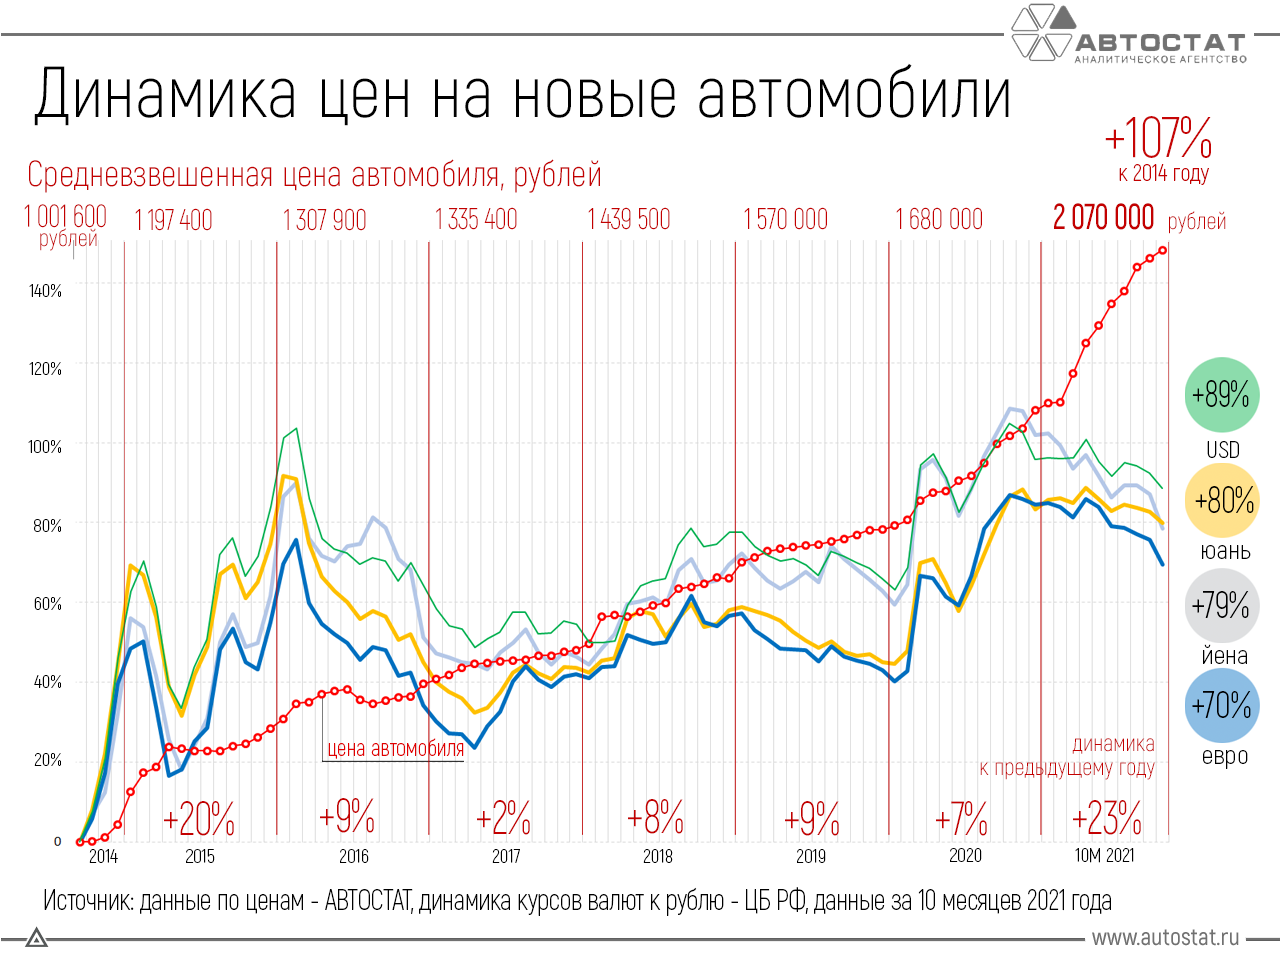

По данным АВТОСТАТА цены на легковые автомобили выросли на ~23% (https://www.autostat.ru/infographics/50105/). Учтём это.

In [2569]:
df.price = df.price * (1-0.23) # может буду подбирать ещё

In [2570]:
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [2571]:
profile

## Обработка признаков

In [2572]:
cat_cols = []
bin_cols = []
num_cols = []

cols_to_drop = []

### bodyType

In [2573]:
df.bodyType.value_counts()

внедорожник 5 дв.          45262
седан                      44867
хэтчбек 5 дв.               7824
лифтбек                     7227
универсал 5 дв.             4875
минивэн                     4071
купе                        2420
компактвэн                  2277
хэтчбек 3 дв.               1281
пикап двойная кабина        1102
купе-хардтоп                 486
фургон                       448
внедорожник 3 дв.            424
кабриолет                    300
родстер                      251
седан-хардтоп                128
микровэн                      32
седан 2 дв.                   25
пикап одинарная кабина        19
пикап полуторная кабина       16
лимузин                       11
внедорожник открытый           6
тарга                          3
фастбек                        1
Name: bodyType, dtype: int64

In [2574]:
df.bodyType = df.bodyType.str.split().str.get(0)

In [2575]:
main_body = list(df.bodyType.value_counts()[:9].index)
other_body = set(df.bodyType.value_counts().index)-set(main_body)

In [2576]:
df.bodyType = df.bodyType.replace(other_body, 'other')

In [2577]:
df.bodyType = df.bodyType.replace({
    'внедорожник': 'suv',
    'седан': 'sedan',
    'хэтчбек': 'hatchback',
    'лифтбек': 'liftback',
    'универсал': 'universal',
    'минивэн': 'minivan',
    'купе': 'coupe',
    'компактвэн': 'compactvan',
    'пикап': 'pickup'
})

In [2578]:
df.bodyType.value_counts()

suv           45692
sedan         44892
hatchback      9105
liftback       7227
universal      4875
minivan        4071
coupe          2420
compactvan     2277
other          1660
pickup         1137
Name: bodyType, dtype: int64

In [2579]:
cat_cols.append('bodyType')

### brand

In [2580]:
df.brand = df.brand.apply(lambda x: x.lower())

In [2581]:
cat_cols.append('brand')

### car_url

In [2582]:
cols_to_drop.append('car_url')

### color

In [2583]:
main_colors = list(df.color.value_counts(normalize=True)[:8].index)
other_colors = set(df.color.value_counts().index)-set(main_colors)

In [2584]:
df.color = df.color.replace(other_colors, 'other')

In [2585]:
df.color = df.color.replace({
    'чёрный': 'black',
    'белый': 'white',
    'серый': 'gray',
    'серебристый': 'silver',
    'синий': 'blue',
    'красный': 'red',
    'коричневый': 'brown',
    'зелёный': 'green'
})

In [2586]:
cat_cols.append('color')

### description

In [2587]:
cols_to_drop.append('description')

### engineDisplacement

In [2588]:
df.engineDisplacement.unique()

array([ 1.2,  1.6,  1.8,  2. ,  1.4,  1.3,  1. ,  3.6,  1.5,  1.9,  2.8,
        1.1,  2.5,  4.2,  3. ,  4. ,  5.9,  2.7,  3.1,  2.4,  5.2,  3.2,
        4.1,  6.3,  2.3,  6. ,  2.2,  3.7,  2.9,  5. ,  3.3,  2.1,  2.6,
       -1. ,  3.5,  1.7,  0.7,  4.4,  4.8,  5.4,  6.6,  4.9,  3.8,  3.4,
        3.9,  4.6,  5.6,  4.5,  5.5,  6.2,  4.7,  4.3,  5.8,  5.3,  5.7])

In [2589]:
df.loc[df['engineDisplacement'] == -1, 'engineDisplacement'] = np.nan # пока что NaN, потом будем обрабатывать

In [2590]:
num_cols.append('engineDisplacement')

### enginePower

In [2591]:
df.loc[df['enginePower'] == -1, 'enginePower'] = np.nan # пока что NaN, потом будем обрабатывать

In [2592]:
num_cols.append('enginePower')

### equipment_dict

In [2593]:
cols_to_drop.append('equipment_dict')

### fuelType

In [2594]:
df.fuelType = df.fuelType.apply(lambda x: str(x).lower())
df.loc[df['fuelType'] == 'бензин, газобаллонное оборудование', 'fuelType'] = 'бенгаз'
df.fuelType = df.fuelType.str.split().str.get(0)
df.fuelType = df.fuelType.apply(lambda x: x.replace(',', ''))
df.loc[df['fuelType'] == 'nan', 'fuelType'] = np.nan

In [2595]:
mask = (df.fuelType == 'электро') | (df.fuelType == 'газ')
df.loc[mask, 'fuelType'] = 'бенгаз'

In [2596]:
df.fuelType.value_counts(dropna=False)

бензин    98211
дизель    21609
NaN        3264
гибрид     2087
бенгаз     1449
Name: fuelType, dtype: int64

In [2597]:
df.fuelType = df.fuelType.replace({'бензин': 'gasoline', 'дизель': 'diesel', 'гибрид': 'hybrid', 'бенгаз': 'bengaz'})

In [2598]:
cat_cols.append('fuelType')

### mileage

In [2599]:
df.loc[df['mileage'] == -1, 'mileage'] = np.nan

In [2600]:
num_cols.append('mileage')

### model_name

In [2601]:
df.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920', 'S3', '200', 'V8', 'E_TRON', 'CR_V', 'ACCORD',
       'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM', 'CROSSTOUR', 'ELYSION',
       'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V', 'SHUTTLE', 'FREED',
       'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO', 'S2000', 'CR_Z',
       'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V', 'CR_X', 'PRELUDE',
       'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA', 'INSPIRE', 'VEZEL',
       'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO', 'AVANCIER', 'SABER',
       'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO', 'AIRWAVE', 'DOMANI',
       'RAFA

In [2602]:
df.model_name = df.car_url.apply(get_model_name)

### name

В некоторых клетках указаны лошадиные силы, но эту информацию мы уже собирали

In [2603]:
df.name.unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ..., 'Volvo XC90 II',
       'Volvo XC90 I Рестайлинг', 'Volvo XC90 I'], dtype=object)

In [2604]:
cols_to_drop.append('name')

**numberOfDoors**

In [2605]:
df.numberOfDoors.value_counts

<bound method IndexOpsMixin.value_counts of 0         5
1         5
2         5
3         5
4         5
         ..
126615    5
126616    5
126617    5
126618    5
126619    5
Name: numberOfDoors, Length: 126620, dtype: int64>

In [2606]:
num_cols.append('numberOfDoors')

**productionDate**

In [2607]:
num_cols.append('productionDate')

**sell_id** - пригодится нам для submission файла, чтобы предсказать цену

In [2608]:
df.sell_id.value_counts(dropna=False)

0             91934
1093920214        1
1101133332        1
1101328116        1
1080540622        1
              ...  
1101120368        1
1091131966        1
1101220412        1
1101300246        1
1095774202        1
Name: sell_id, Length: 34687, dtype: int64

In [2609]:
sell_ids = df.loc[df.sell_id>0, 'sell_id']

In [2610]:
sell_ids.count() == test.sell_id.count()

True

In [2611]:
cols_to_drop.append('sell_id')

**vehicleTransmission**

In [2612]:
df.vehicleTransmission.value_counts(dropna=False)

автоматическая      68644
механическая        25627
вариатор            15939
роботизированная    13146
NaN                  3264
Name: vehicleTransmission, dtype: int64

In [2613]:
df.vehicleTransmission = df.vehicleTransmission.replace({
    'автоматическая': 'automatic', 
    'механическая': 'mechanic',
    'вариатор': 'variator',
    'роботизированная': 'robotic'
})

In [2614]:
cat_cols.append('vehicleTransmission')

**vendor**

Всего 2 категории, примерно 45 на 55

In [2615]:
df.vendor.value_counts(dropna=False)

EUROPEAN    72830
JAPANESE    53790
Name: vendor, dtype: int64

In [2616]:
cat_cols.append('vendor')

**owners**

In [2617]:
df.owners.value_counts(dropna=False)

3 или более    60303
1 владелец     24191
2 владельца    20126
1 владелец      9459
2 владельца     9270
NaN             3271
Name: owners, dtype: int64

In [2618]:
df.owners = df.owners.str.split().str.get(0)

In [2619]:
df.owners = df.owners.astype('float64')

In [2620]:
num_cols.append('owners')

**ownership**

В данных указано сколько лет и месяцев машина была во владении

In [2621]:
df.ownership.value_counts(dropna=False)

NaN                    88755
2 месяца                 859
3 месяца                 824
1 год                    748
11 месяцев               728
                       ...  
22 года и 7 месяцев        1
29 лет                     1
26 лет и 3 месяца          1
25 лет и 4 месяца          1
31 год и 10 месяцев        1
Name: ownership, Length: 341, dtype: int64

In [2622]:
df.ownership = df.ownership.apply(get_ownership)

In [2623]:
num_cols.append('ownership')

**licence**

In [2624]:
df.licence.value_counts(dropna=False)

Оригинал    103748
Дубликат     19606
NaN           3266
Name: licence, dtype: int64

In [2625]:
df.licence = df.licence.replace({'Оригинал': 'original', 'Дубликат': 'duplicate'})

In [2626]:
cat_cols.append('licence')

**driving_gear**

In [2627]:
df.driving_gear.value_counts(dropna=False)

передний    54684
полный      53860
задний      14812
NaN          3264
Name: driving_gear, dtype: int64

In [2628]:
df.driving_gear = df.driving_gear.replace({'передний': 'forward', 'полный': 'full', 'задний': 'back'})

In [2629]:
cat_cols.append('driving_gear')

**steering_wheel**

In [2630]:
df.steering_wheel.value_counts(dropna=False)

Левый     111911
Правый     11445
NaN         3264
Name: steering_wheel, dtype: int64

In [2631]:
df.steering_wheel = df.steering_wheel.replace({'Левый': 'left', 'Правый': 'right'})

In [2632]:
cat_cols.append('steering_wheel')

**condition**

In [2633]:
df.condition.value_counts()

Не требует ремонта    123349
Name: condition, dtype: int64

In [2634]:
cols_to_drop.append('condition')

**customs**

In [2635]:
df.customs.value_counts()

Растаможен    123345
Name: customs, dtype: int64

In [2636]:
cols_to_drop.append('customs')

**super_gen** - есть некоторая информация чтобы заполнить пропуски - engineDisplacement, fuelType, vehicleTransmission

In [2637]:
df.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [2638]:
cols_to_drop.append('super_gen')

### complectation_dict

In [2639]:
cols_to_drop.append('complectation_dict')

## Работа с пропусками и дупликатами

### Дупликаты

In [2640]:
print(sum(df.duplicated()))
df.shape

1618


(126620, 29)

In [2641]:
df.drop_duplicates(inplace=True)
df.shape

(125002, 29)

### Пропуски

Пропуски имеются в следующих признаках:  
    - bodyType (2.6%)  
    - complectation_dict (22.3%) - будет убираться в любом случае  
    - equipment_dict (7.9%) - будет убираться в любом случае  
    - fuelType (2.6%)  
    - model_name (2.6%)  
    - vehicleTransmission (2.6%) 3264 записи, как и в предыдущих вариантах. Может будет смысл убрать 'бракованные строки'  
    - owners (2.6%)  
    - ownership (70.1%)  
    - licence (2.6%)  
    - driving_gear (2.6%)  
    - steering_wheel (2.6%)  
    - condition (2.6%)  
    - customs (2.6%) 
      


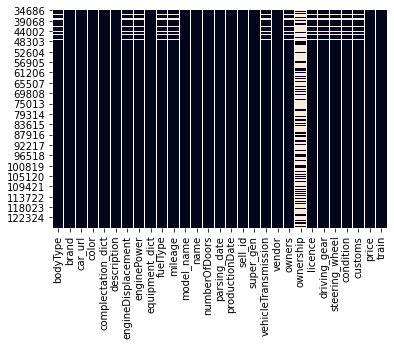

In [2642]:
sns.heatmap(df[df.train == 1].isna(), cbar=False);

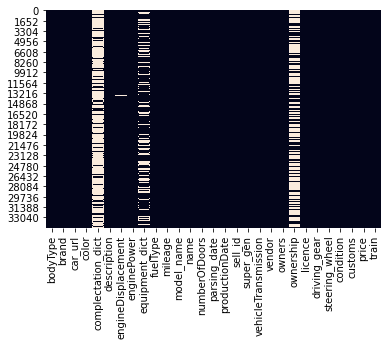

In [2643]:
sns.heatmap(df[df.train == 0].isna(), cbar=False);

Поскольку в train много "полосок", есть подозрение, что много ссылок собралось пустыми. Уберём эти строки полностью

In [2644]:
df.isna().sum()

bodyType                2940
brand                      0
car_url                    0
color                      0
complectation_dict     28268
description                0
engineDisplacement      2995
enginePower             2940
equipment_dict          9996
fuelType                2940
mileage                 2940
model_name                 0
name                       0
numberOfDoors              0
parsing_date               0
productionDate             0
sell_id                    0
super_gen                  0
vehicleTransmission     2940
vendor                     0
owners                  2947
ownership              87540
licence                 2942
driving_gear            2940
steering_wheel          2940
condition               2947
customs                 2951
price                      0
train                      0
dtype: int64

In [2645]:
df = df.dropna(subset=['bodyType', 'enginePower', 'fuelType', 'mileage', 'vehicleTransmission', 'owners', 'driving_gear', 'steering_wheel', 'condition', 'customs'])

**engineDisplacement**

In [2646]:
engine_dict = df.groupby(['model_name']).engineDisplacement.median().to_dict()

In [2647]:
check = df.copy()

In [2648]:
df.engineDisplacement = df.engineDisplacement.fillna(value=engine_dict)

In [2649]:
engine_mode = df.engineDisplacement.mode()[0]
df.engineDisplacement = df.engineDisplacement.fillna(engine_mode)

**licence**

In [2650]:
df.licence = df.licence.fillna('original')

Осталось только 3 - complectation_dict, equipment_dict, ownership

**ownership** - уберём, т.к. слишком много NaN

In [2651]:
df = df.drop(['ownership'], axis=1)

In [2652]:
num_cols.remove('ownership')

## Label Encoding

In [2653]:
cols_to_drop.append('model_name')
cols_to_drop.append('parsing_date')

In [2654]:
data = df.copy()

In [2655]:
data = dummy_cols(data, cat_cols)

In [2656]:
#for colum in ['bodyType', 'brand', 'engineDisplacement']:
#    data[colum] = data[colum].astype('category').cat.codes

In [2657]:
X = data.query('train == 1').drop(['train'] + cols_to_drop + ['price'], axis=1)
X_sub = data.query('train == 0').drop(['train'] + cols_to_drop, axis=1)
y = data.query('train == 1')['price']

In [2658]:
#encoder = ce.CatBoostEncoder()

In [2659]:
#encoder.fit(X, y)

## Train Split

In [2660]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [2661]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [2662]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 97.14%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [2663]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [2664]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.00%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [2665]:
np.log(y_train)

87407     14.084774
104648    13.397492
97464     13.266464
106997    14.635951
46006     14.196000
            ...    
43784     14.763106
94141     14.195473
116085    12.625276
35548     11.003099
54138     13.447674
Name: price, Length: 69880, dtype: float64

In [2666]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')


In [2667]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [2668]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.19%


# Naive Submission

In [2669]:
predict_submission

array([ 603091.50977524,  857061.2432074 ,  885132.02112308, ...,
        231028.13148721, 1331677.4987696 , 1029671.02462312])

In [2670]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'naive_submission_{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.030915e+05
1,1100549428,8.570612e+05
2,1100658222,8.851320e+05
3,1100937408,6.980206e+05
4,1101037972,7.778426e+05
5,1100912634,7.739847e+05
6,1101228730,7.554531e+05
7,1100165896,4.114471e+05
8,1100768262,1.880397e+06
9,1101218501,8.783733e+05


В итоге получили **MAPE 15%** на ЛБ!

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing

## Анализ признаков

In [2671]:
df.drop(['complectation_dict', 'equipment_dict'], axis=1).nunique()

bodyType                   10
brand                      12
car_url                121324
color                       9
description            113416
engineDisplacement         54
enginePower               336
fuelType                    4
mileage                 32680
model_name                544
name                     5753
numberOfDoors               5
parsing_date           122022
productionDate             75
sell_id                 34687
super_gen               93110
vehicleTransmission         4
vendor                      2
owners                      3
licence                     2
driving_gear                3
steering_wheel              2
condition                   1
customs                     1
price                    7177
train                       2
dtype: int64

Чтобы не путаться заново назначим все категории и оттуда будем работать.

In [2672]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'owners', 'driving_gear']
bin_cols = ['vendor', 'licence', 'steering_wheel']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'productionDate']

cols_to_drop = ['equipment_dict', 'complectation_dict', 'car_url', 'description', 'name', 'sell_id', 'condition', 'customs', 'super_gen', 'model_name', 'parsing_date']


In [2673]:
cat_cols, '------', num_cols,'------', cols_to_drop

(['bodyType',
  'brand',
  'color',
  'fuelType',
  'numberOfDoors',
  'vehicleTransmission',
  'owners',
  'driving_gear'],
 '------',
 ['engineDisplacement', 'enginePower', 'mileage', 'productionDate'],
 '------',
 ['equipment_dict',
  'complectation_dict',
  'car_url',
  'description',
  'name',
  'sell_id',
  'condition',
  'customs',
  'super_gen',
  'model_name',
  'parsing_date'])

### num_cols

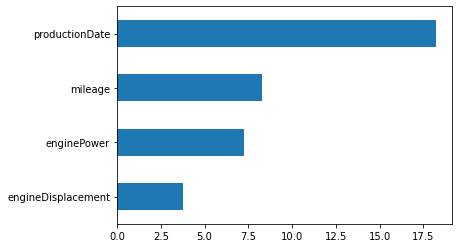

In [2674]:
barh_plot(df, num_cols, 'price')

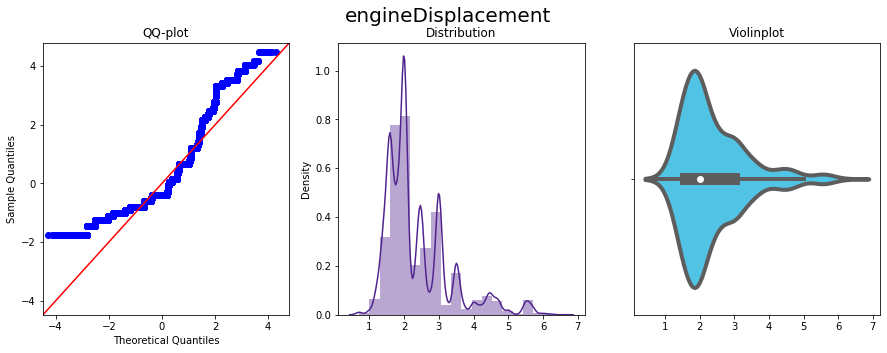

Bot: -0.5, Top: 5.1, Outliers: 2653


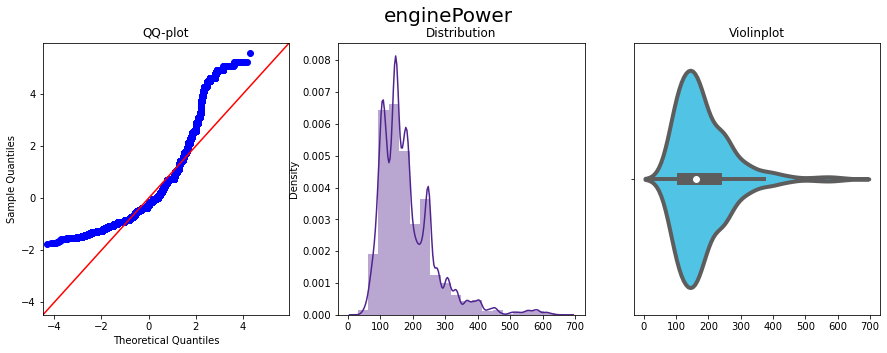

Bot: -32.5, Top: 379.5, Outliers: 4870


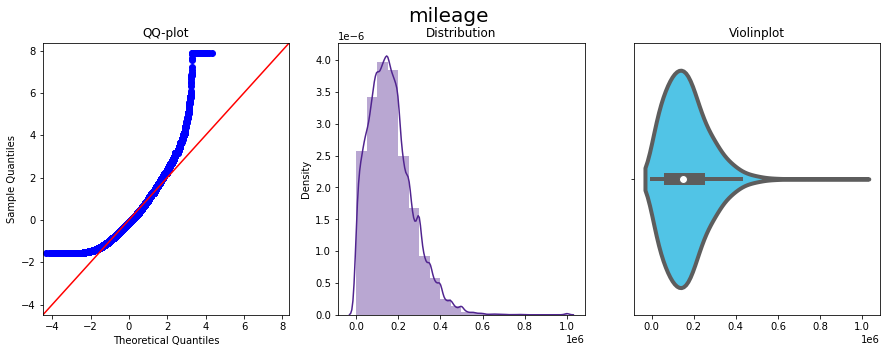

Bot: -114500.0, Top: 425500.0, Outliers: 2334


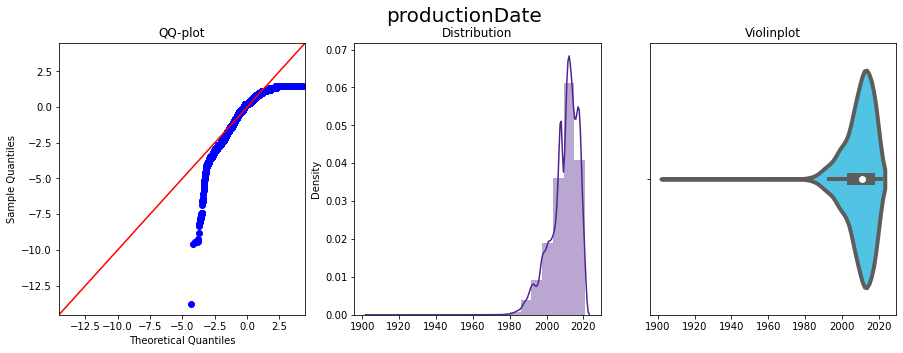

Bot: 1992.5, Top: 2028.5, Outliers: 4405


In [2675]:
for col in num_cols:
    num_vis(df[col], title=col)
    find_outliers(df[col])

Нет признаков с нормальным распределением  


Rank of Matrix: 4
Determinant of matrix: 0.1324
Shape of matrix: (4, 4)


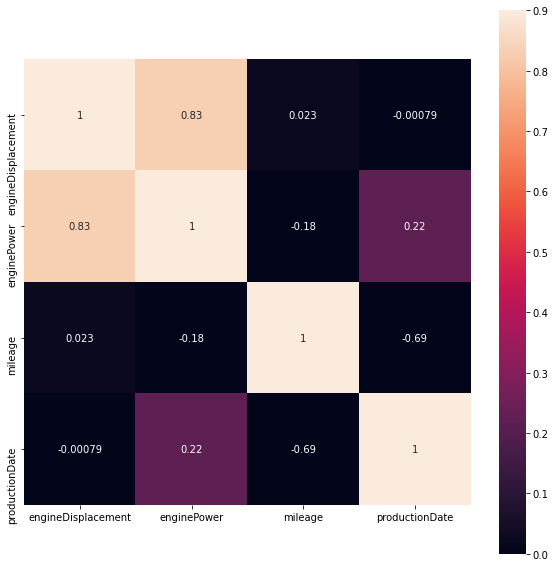

In [2676]:
corr_matrix(df[num_cols])

Очень большая корреляция у **engineDisplacement** и **enginePower**, **productionDate**, **mileage** Объединим с помощью PCA

**engineDisplacement** и **enginePower**

In [2677]:
df = pca_cols(df, 'engineDisplacement', 'enginePower')

In [2678]:
num_cols.remove('engineDisplacement')
num_cols.remove('enginePower')
num_cols.append('engineDisplacement_enginePower_PCA')

**productionDate**, **mileage**

In [2679]:
#df = pca_cols(df, 'productionDate', 'mileage')

In [2680]:
#num_cols.remove('productionDate')
#num_cols.remove('mileage')
#num_cols.append('productionDate_mileage_PCA')

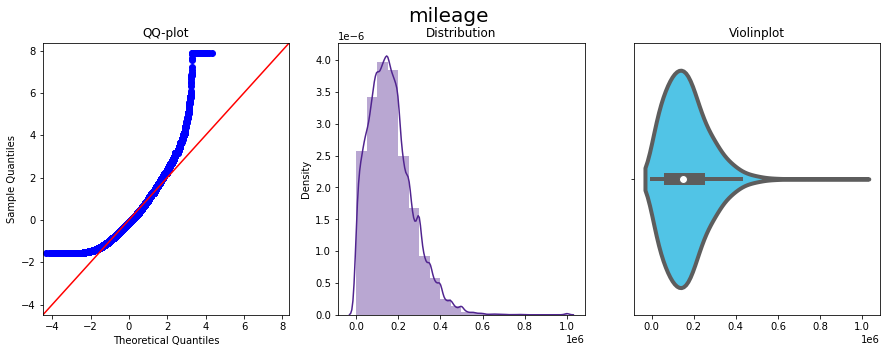

Bot: -114500.0, Top: 425500.0, Outliers: 2334


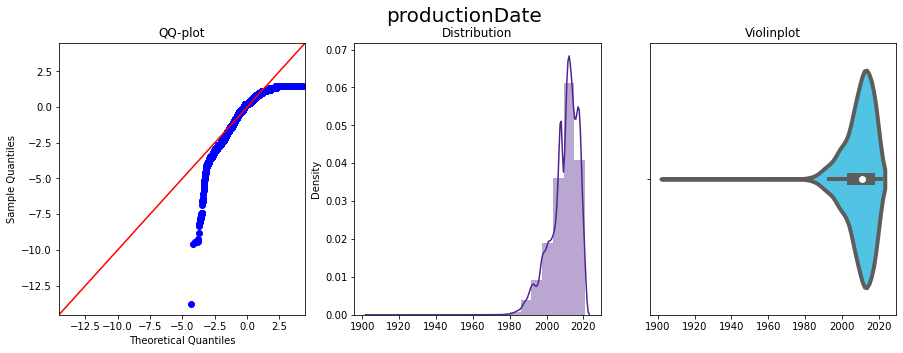

Bot: 1992.5, Top: 2028.5, Outliers: 4405


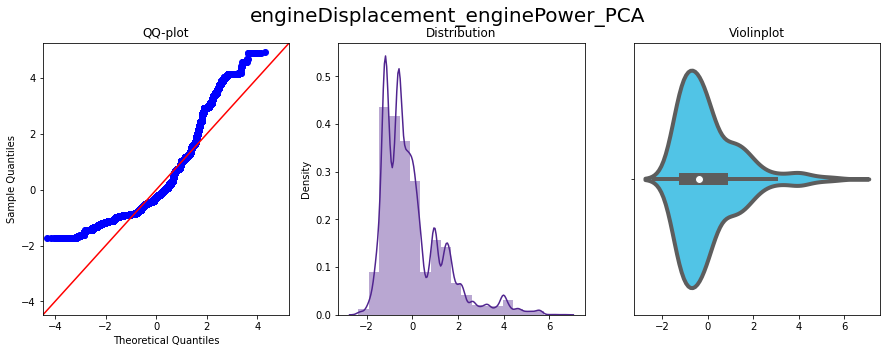

Bot: -3.429, Top: 3.058, Outliers: 5365


In [2681]:
for col in num_cols:
    num_vis(df[col], title=col)
    find_outliers(df[col])

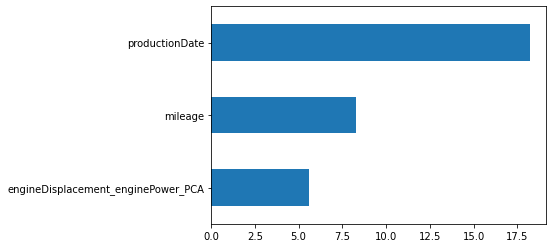

In [2682]:
barh_plot(df, num_cols, 'price')

In [2683]:
log_df = df.copy()

In [2684]:
log_df[num_cols] = np.log(log_df[num_cols] + 3)

In [2685]:
log_df[num_cols].isna().sum()

mileage                               0
productionDate                        0
engineDisplacement_enginePower_PCA    0
dtype: int64

Методом "тыка" выяснилось, что логарифмирование ни на что не влияет

In [2686]:
#df[num_cols] = log_df[num_cols]

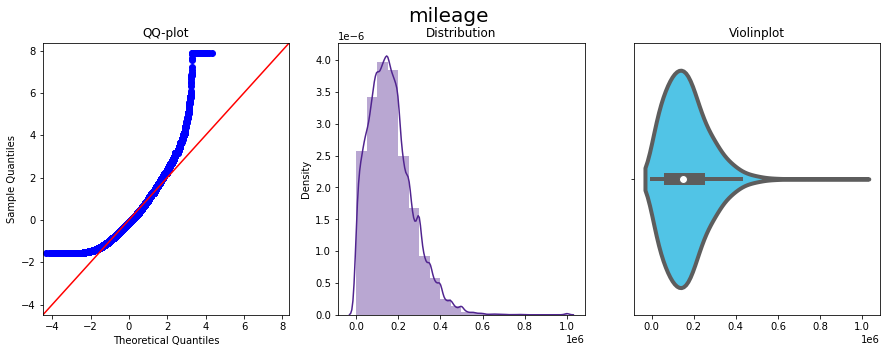

Bot: -114500.0, Top: 425500.0, Outliers: 2334


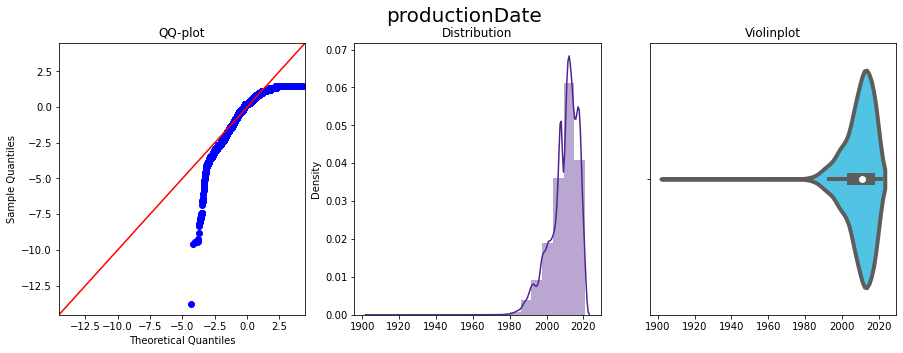

Bot: 1992.5, Top: 2028.5, Outliers: 4405


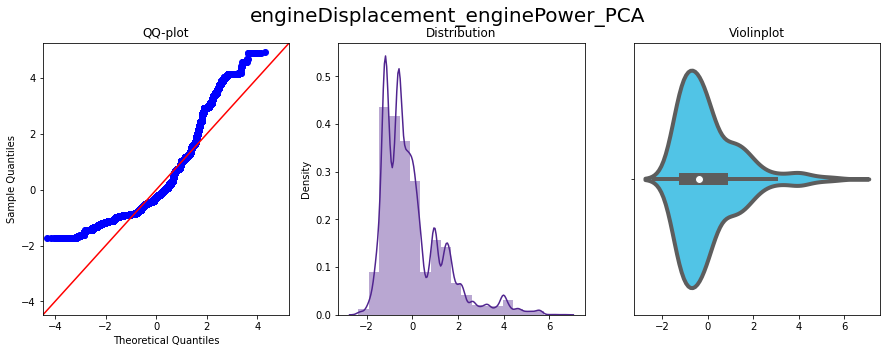

Bot: -3.429, Top: 3.058, Outliers: 5365


In [2687]:
for col in num_cols:
    num_vis(df[col], title=col)
    find_outliers(df[col])

После логарифмирования получилось нормальное расределение у обоих признаков

In [2688]:
temp_data = df.copy()

In [2689]:
temp_data = dummy_cols(temp_data, cat_cols+bin_cols)

In [2690]:
temp_X = temp_data.query('train == 1').drop(cols_to_drop + ['train'] + ['price'], axis=1)
temp_X_sub = temp_data.query('train == 0').drop(cols_to_drop + ['train'] + ['price'], axis=1)
temp_y = temp_data.query('train == 1')['price']

In [2691]:
X_train, X_test, y_train, y_test = train_test_split(temp_X, temp_y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [2692]:
temp_model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
temp_model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

temp_model.save_model('catboost_temp_model.model')

In [2693]:
predict_test = np.exp(temp_model.predict(X_test))
predict_submission = np.exp(temp_model.predict(temp_X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.26%


In [2694]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.410192e+05
1,1100549428,8.701122e+05
2,1100658222,8.827255e+05
3,1100937408,7.110947e+05
4,1101037972,7.629418e+05
5,1100912634,7.671724e+05
6,1101228730,7.501783e+05
7,1100165896,4.133594e+05
8,1100768262,1.906904e+06
9,1101218501,8.562067e+05


In [2697]:
#regressor = RandomForestRegressor(random_state=SEED, n_jobs=-1)
#regressor.fit(x, y)
result = pd.DataFrame(data=temp_model.feature_importances_, index=temp_X.columns)

In [2698]:
result

,0
mileage,8.443098
productionDate,46.678787
engineDisplacement_enginePower_PCA,22.966915
bodyType_compactvan,0.077916
bodyType_coupe,0.118331
bodyType_hatchback,0.165165
bodyType_liftback,0.028481
bodyType_minivan,0.954240
bodyType_other,0.187946
bodyType_pickup,0.037674


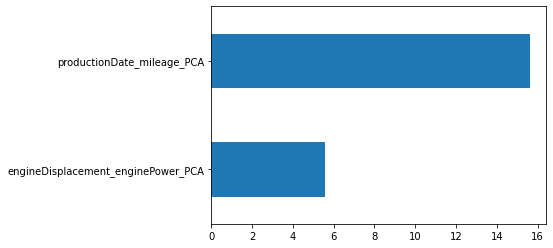

In [2519]:
barh_plot(df, num_cols, 'price')

# Feature Engineering

Есть смысл достать consumption-hiway, conumption-mixed, consumption-city из complectation_dict

In [ ]:
df_equip = df.copy()

In [ ]:
#df_equip.equipment_dict = df_equip.equipment_dict.apply(equipment_to_dict)

In [ ]:
'''def get_equipment_features(data, column):
    index = 0
    for i in data[column]:
        try:
            for j in i:
                if f"equip_{j.replace('-', '_')}" not in data.columns:
                    data[f"equip_{j.replace('-', '_')}"] = 0
                    data[f"equip_{j.replace('-', '_')}"][index] = 1
        except:
            print(i)
            pass
        index+=1
    return data'''

In [ ]:
df_equip.equipment_dict = df_equip.equipment_dict.apply(lambda x: )

In [ ]:
df_equip.equipment_dict[1]

In [ ]:
for i in df_equip.equipment_dict[0]:
    if df_equip[i.replace('-','_')] in df_equip.columns
        df_equip[i.replace('-','_')] = 0
    df_equip[i.replace('-','_')][0] = df_equip.equipment_dict[0][i]


In [ ]:
for i in df_equip['equipment_dict']:
    count
    print(i)

In [ ]:
a = {'a': 1,
    'b': 2}

In [ ]:
for i in a:
    print(i)

In [ ]:
data.info()

In [ ]:
data = pca_cols(data, 'engineDisplacement', 'enginePower')
data = pca_cols(data, 'productionDate', 'mileage')

In [ ]:
data.to_csv('df_to_show.csv')

In [ ]:
data.info()